Importing libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from pa3_demo import load_obj_each_frame, draw_target_object_center

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


#### Visualization
1. Object centers tracked over time

In [3]:
video_file = "./commonwealth.mp4"
frame_dict = load_obj_each_frame(data_file="./object_to_track.json")
draw_target_object_center(video_file=video_file, obj_centers=frame_dict["obj"])

In [4]:
frame_number=100
cap = cv.VideoCapture(video_file)
frames_count, fps, width, height = cap.get(cv.CAP_PROP_FRAME_COUNT), cap.get(cv.CAP_PROP_FPS), cap.get(cv.CAP_PROP_FRAME_WIDTH), cap.get(cv.CAP_PROP_FRAME_HEIGHT)
# check for valid frame number
if frame_number >= 0 & frame_number <= frames_count:
    # set frame position
    cap.set(cv.CAP_PROP_POS_FRAMES,frame_number)

In [5]:
print(f"Frames per second: {fps}")
print(f"Total number of frames: {frames_count}")

xs = [xy[0] for xy in frame_dict["obj"]]
ys = [xy[1] for xy in frame_dict["obj"]] #  if xy[0] != -1

assert len(xs) == len(ys) == frames_count

Frames per second: 30.0
Total number of frames: 249.0


#### Alpha-Beta Filter

In [6]:
def alpha_beta_filter(measurements: list, x0: float, dx: float, alpha: float, beta:float, dt: float):
    """Alpha-Beta filter for one state variable

    Args:
        measurements (list): List of measurements observed at all time steps - to be filtered
        x0 (float): Initial value of state variabke
        dx (float): Initial rate of change of state variable
        alpha (float): Alpha scale factor
        beta (float): Beta scale factor
        dt (float): Length of time step
    """
    x_init = x0
    filtered_res = []
    for measure in measurements:
        # Predict
        x_pred = x_init + (dx * dt)
        dx = dx

        # Update
        if measure != -1: 
            resid = measure - x_pred
        else:
            resid = 0
        dx = dx + beta * resid / dt
        x_init = x_pred + alpha * resid
        
        filtered_res.append(x_init)
    return np.array(filtered_res)

In [7]:
alpha_tuned = 0.85
beta_tuned = 0.05

# Predicted X positions
pred_xpos = alpha_beta_filter(measurements=xs,
                              x0=300.,
                              dx=1.,
                              alpha=alpha_tuned,
                              beta=beta_tuned,
                              dt=1)

# Predicted Y positions
pred_ypos = alpha_beta_filter(measurements=ys,
                              x0=250.,
                              dx=1.,
                              alpha=alpha_tuned,
                              beta=beta_tuned,
                              dt=1)

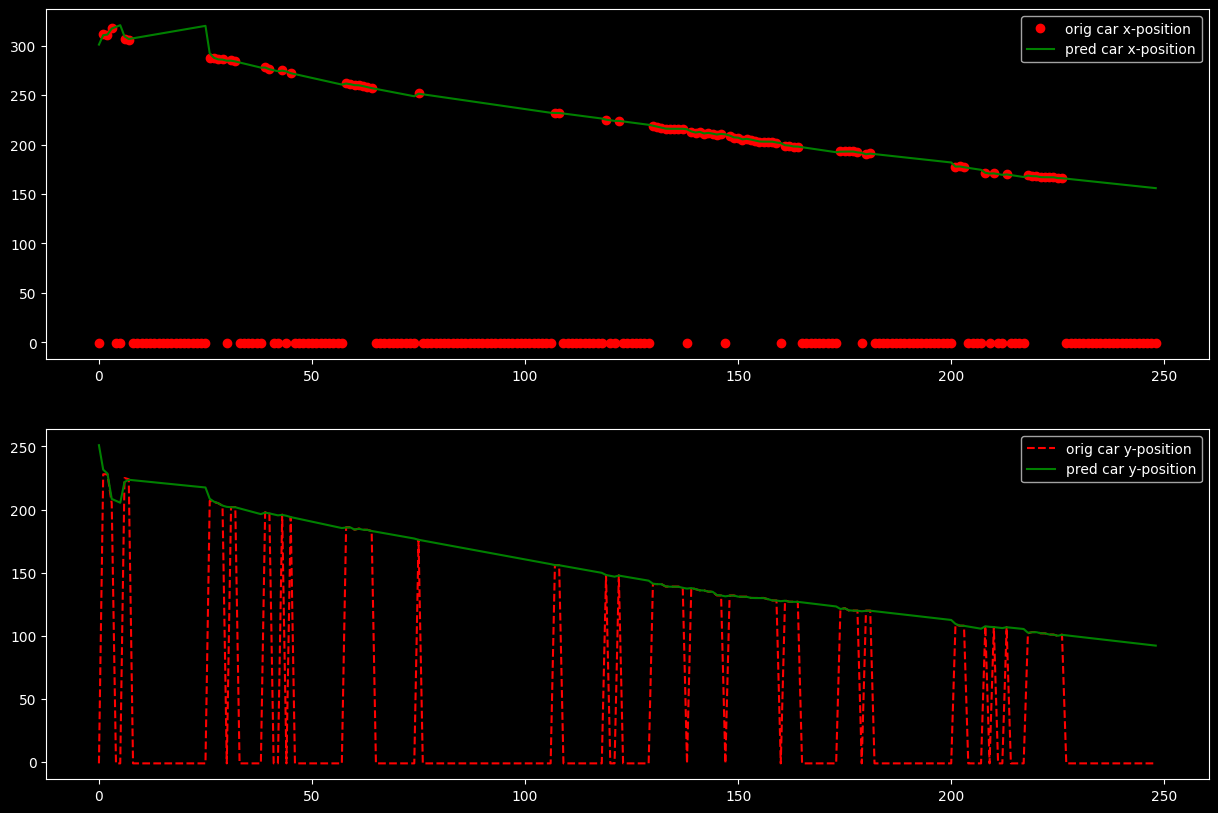

In [8]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.plot(xs, "ro", label="orig car x-position")
plt.plot(pred_xpos, "g-", label="pred car x-position")
plt.legend()


plt.subplot(212)
plt.plot(ys, "r--", label="orig car y-position")
plt.plot(pred_ypos, "g-", label="pred car y-position")
plt.legend()
plt.show()

In [9]:
predictions = list([x, y] for x, y in zip(pred_xpos, pred_ypos))
draw_target_object_center(video_file=video_file, obj_centers=predictions, output_file="part_1_alpha_beta_filter.mp4")

In [10]:
frames_count

249.0

In [11]:
len(predictions)

249